In [1]:
from postgres.PostgreSQL import PostgreSQL
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
import os, sys
import matplotlib.pyplot as plt




In [2]:
from postgres.PostgreSQL import PostgreSQL
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.naive_bayes import MultinomialNB
import os, sys

path = ''
#path = "/data/forecasts/"

def get_value_from_wf_df(df,ymd,col):
    return list(df[df['ymd']==ymd][col])[0]

def get_neighborhood_poverty(df, nbh):
    pov = list(df[df['neighborhood']==nbh]['percent_poverty'])
    if len(pov) == 1:
        return pov[0]
    else:
        return 'NA'

def create_dummies(vect,v,n):
    for i in range(n):
        if i == v:
            vect.append(1)
        else:
            vect.append(0)
    return vect

def ymd_check(vect,ymd,v):
    if ymd==v:
        vect.append(1)
    else:
        vect.append(0)
    return vect

def create_forecasts(path, mymap):
    n = sorted(mymap.keys())
    num = len(n)
    results = np.random.rand(num,5)
    with open(path + 'random_forecasts.csv', 'w') as myfile:
        for i in range(num):
            my_str = n[i]
            for j in range(5):
                my_str += ',' + str(results[i][j])
            myfile.write(my_str + '\n')

def main():
    with PostgreSQL(database = 'pittsburgh') as psql:
        query = "SELECT incidenttime, incidentneighborhood FROM police_incident_blotter_archive_2"
        psql.execute(query)
        rows = psql.cur.fetchall()

    print('Retrieved crime data')

    # place crime data into a DataFrame
    crime_df = pd.DataFrame(rows, columns=['incidenttime', 'neighborhood'])

    # parse the string dates into datetime format and create various date-based features
    dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %H:%M')
    crime_df['datetime'] = crime_df['incidenttime'].apply(dateparse)
    crime_df['date'] = crime_df['datetime'].map(lambda x: x.date())
    crime_df['year'] = crime_df['datetime'].map(lambda x: int(x.strftime('%Y')))
    crime_df['month'] = crime_df['datetime'].map(lambda x: int(x.strftime('%m')))
    crime_df['day'] = crime_df['datetime'].map(lambda x: int(x.strftime('%d')))
    crime_df['dayofweek'] = crime_df['datetime'].map(lambda x: x.dayofweek)
    crime_df['ymd'] = crime_df['datetime'].map(lambda x: int(10000*x.year + 100*x.month + x.day))
    crime_df['key'] = crime_df['ymd'].map(str) + crime_df['neighborhood']

    # create weekday dummies
    weekday_dummies = pd.get_dummies(crime_df['dayofweek'])
    weekday_dummies = weekday_dummies.rename(columns={0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'})

    # create month dummies
    month_dummies = pd.get_dummies(crime_df['month'])
    month_dummies = month_dummies.rename(columns={1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun', 7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'})

    # join dummies to crime_df
    crime_df = pd.concat([crime_df,weekday_dummies,month_dummies], axis=1)

    # count incidents by date and neighborhood
    agg_df = crime_df.groupby(['ymd','neighborhood'], as_index=False)['incidenttime'].count()
    agg_df = agg_df.rename(columns={'incidenttime':'num_incidents'})
    agg_df['key'] = agg_df['ymd'].map(str) + agg_df['neighborhood']

    # feature creation Jan 1 dummy
    agg_df['jan1'] = agg_df['ymd'].map(lambda x: np.where(str(x)[-4:]=='0101',1,0))

    # feature creation 1st of month dummy
    agg_df['1stm'] = agg_df['ymd'].map(lambda x: np.where(str(x)[-2:]=='01',1,0))

    # feature creation 15th of month dummy
    agg_df['15thm'] = agg_df['ymd'].map(lambda x: np.where(str(x)[-2:]=='15',1,0))

    # feature creation Dec 25 dummy
    agg_df['dec25'] = agg_df['ymd'].map(lambda x: np.where(str(x)[-4:]=='1225',1,0))

    # add dummies to aggregates
    dummies = ['key','date','mon','tue','wed','thu','fri','sat','sun','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    agg_df = pd.merge(left=agg_df, right=crime_df[dummies], on=['key'], how='left')

    print('Aggregated crime data and created features')

    # query for poverty data
    with PostgreSQL(database = 'pittsburgh') as psql:
        query = "SELECT neighborhood, percent_poverty FROM poverty"
        psql.execute(query)
        rows = psql.cur.fetchall()

    # place poverty data into a DataFrame
    poverty_df = pd.DataFrame(rows, columns=['neighborhood', 'percent_poverty'])

    # join poverty to aggregates
    agg_df = pd.merge(left=agg_df, right=poverty_df, on=['neighborhood'], how='left')

    print('Retrieved and joined demographic data')

    # query for weather data
    with PostgreSQL(database = 'pittsburgh') as psql:
        query = "SELECT year, month, day, temp_f_high, events FROM weather WHERE year > 2004"
        psql.execute(query)
        rows = psql.cur.fetchall()

    # place weather data into a DataFrame
    weather_df = pd.DataFrame(rows, columns=['year', 'month', 'day', 'temp_high', 'events'])
    weather_df['ymd'] = 10000 * weather_df['year'] + 100 * weather_df['month'] + weather_df['day']
    weather_df['weather'] = weather_df['events'].map(lambda x: np.where(x=='NULL',0,1))

    # join weather to aggregates
    columns = ['ymd','temp_high','weather']
    agg_df = pd.merge(left=agg_df, right=weather_df[columns], on=['ymd'], how='left')
    agg_df = agg_df[agg_df['neighborhood']!='']

    print('Retrieved, transformed and joined weather data')

    # add neighborhood numbers
    mymap = {}
    nbh = sorted(list(set(list(agg_df['neighborhood']))))
    for i in range(len(nbh)):
        mymap[nbh[i]] = i+1
    agg_df['nbh'] = agg_df['neighborhood'].map(lambda x: mymap[x])

    # create final table of feature by removing duplicate rows
    agg_df = agg_df.drop_duplicates()
    agg_df = agg_df.reset_index(drop=True)

    # create neighborhood dummies
    agg_df = pd.concat([agg_df, pd.get_dummies(agg_df['nbh'])], axis=1); agg_df

    df = agg_df[np.isfinite(agg_df['percent_poverty'])]
    df = df[np.isfinite(df['temp_high'])]

    print('Clean data for null or infinity values')

    y = df['num_incidents']
    # regression features (exclude 'sun' and 'dec' to avoid multicolinearity)
    features = ['percent_poverty', 'temp_high', 'weather', 'jan1', '1stm', '15thm', 'dec25', 'mon', 'tue', 'wed', 'thu', 'fri',
           'sat', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul',
           'aug', 'sep', 'oct', 'nov' ]
    for key in mymap.keys():
        features.append(mymap[key])
    # exclude last neighborhood to avoid multicolinearity
    features = features[:-1] 
    X = df[features]

    clf = MultinomialNB()
    clf.fit(X,y)

    print('Fitted forecast model')

    # Call for weather forecast data to create prediction vectors
    with PostgreSQL(database = 'pittsburgh') as psql:
        query = "SELECT year, month, day, temp, events FROM weather_forecasts"
        psql.execute(query)
        rows = psql.cur.fetchall()

    weather_forecasts_df = pd.DataFrame(rows, columns=['year', 'month', 'day', 'temp', 'events'])
    weather_forecasts_df['ymd'] = 10000 * weather_forecasts_df['year'] + 100 * weather_forecasts_df['month'] + weather_forecasts_df['day']
    weather_forecasts_df

    wf_df = weather_forecasts_df.groupby(['ymd'], as_index=False)['temp'].max()
    events = weather_forecasts_df.groupby(['ymd'], as_index=False)['events'].count()
    events['weather'] = events['events'].map(lambda x: np.where(x>0,1,0))
    wf_df = pd.concat([wf_df,events['weather']], axis=1)

    # feature creation month
    wf_df['month'] = wf_df['ymd'].map(lambda x: int(str(x)[-4:-2]))

    # feature creation day of week
    dateparse = lambda x: pd.to_datetime(str(x), format='%Y%m%d')
    wf_df['datetime'] = wf_df['ymd'].apply(dateparse)
    wf_df['dayofweek'] = wf_df['datetime'].map(lambda x: x.dayofweek)

    # get list of forecast dates
    ymd_list = list(wf_df['ymd'])

    if len(ymd_list) == 6:
        ymd_list = ymd_list[1:]

    # populate first row of results
    results = []
    result = []
    result.append('Neighborhood') 
    for ymd in ymd_list:
        result.append(get_value_from_wf_df(wf_df,ymd,'datetime'))
    results.append(result)
    for neighborhood in mymap.keys():

        # prediction result vector for neighborhood
        result = [neighborhood]

        # feature inputs
        nbh = mymap[neighborhood]
        max_nbh = np.max(list(mymap.values()))
        poverty = get_neighborhood_poverty(poverty_df,neighborhood)
        if poverty == 'NA': # can't make a forecast
            result.append('NA')
            result.append('NA')
            result.append('NA')
            result.append('NA')
            result.append('NA')
        else:               
            for ymd in ymd_list:
                # feature inputs
                temp = get_value_from_wf_df(wf_df,ymd,'temp')
                weather = get_value_from_wf_df(wf_df,ymd,'weather')
                month = get_value_from_wf_df(wf_df,ymd,'month')
                dayofweek = get_value_from_wf_df(wf_df,ymd,'dayofweek')

                # create feature vector
                curr_vect = []
                # add poverty
                curr_vect.append(poverty)
                # add temp
                curr_vect.append(temp)
                # add weather
                curr_vect.append(weather)
                # Jan 1
                curr_vect = ymd_check(curr_vect, str(ymd)[-4:], '0101')
                # 1st of month
                curr_vect = ymd_check(curr_vect, str(ymd)[-2:], '01')
                # 15th of month
                curr_vect = ymd_check(curr_vect, str(ymd)[-2:], '15')
                # Dec 25
                curr_vect = ymd_check(curr_vect, str(ymd)[-2:], '1225')
                # add weekday dummies
                curr_vect = create_dummies(curr_vect,dayofweek,6)
                # add month dummies
                curr_vect = create_dummies(curr_vect,month,11)
                # add weekday dummies
                curr_vect = create_dummies(curr_vect,nbh,max_nbh-1)
                # print(curr_vect)
                pred = 0
                try:
                    pred = round(clf.predict_proba(np.array(curr_vect).reshape(1, -1)).item(0),4)
                except:
                    pass
                result.append(pred)
        results.append(result)

    try:
        os.mkdir(path)
    except:
        pass

    with open(path + 'forecasts.csv', 'w') as myfile:
        for result in results:
            my_str = ''
            for i in result:
                my_str += str(i) + ','
            my_str = my_str[:-1]
            myfile.write(my_str + '\n')                                           
                                             
    create_forecasts(path, mymap)

    print('Success!')
    print('Written forecasts to files in /data/forecasts')
                                             
if __name__ == '__main__':
    main()

Retrieved crime data
Aggregated crime data and created features
Retrieved and joined demographic data
Retrieved, transformed and joined weather data
Clean data for null or infinity values
Fitted forecast model
Success!
Written forecasts to files in /data/forecasts


In [13]:
path = "/data/forecasts/"

def get_value_from_wf_df(df,ymd,col):
    return list(df[df['ymd']==ymd][col])[0]

def get_neighborhood_poverty(df,nbh):
    pov = list(df[df['neighborhood']==nbh]['percent_poverty'])
    if len(pov) == 1:
        return pov[0]
    else:
        return 'NA'

def create_dummies(vect,v,n):
    for i in range(n):
        if i == v:
            vect.append(1)
        else:
            vect.append(0)
    return vect

def ymd_check(vect,ymd,v):
    if ymd==v:
        curr_vect.append(1)
    else:
        curr_vect.append(0)
    return vect

# call for crime incident data
with PostgreSQL(database = 'pittsburgh') as psql:
    query = "SELECT incidenttime, incidentneighborhood FROM police_incident_blotter_archive_2"
    psql.execute(query)
    rows = psql.cur.fetchall()

print('Retrieved crime data')

# place crime data into a DataFrame
crime_df = pd.DataFrame(rows, columns=['incidenttime', 'neighborhood'])

# parse the string dates into datetime format and create various date-based features
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %H:%M')
crime_df['datetime'] = crime_df['incidenttime'].apply(dateparse)
crime_df['date'] = crime_df['datetime'].map(lambda x: x.date())
crime_df['year'] = crime_df['datetime'].map(lambda x: int(x.strftime('%Y')))
crime_df['month'] = crime_df['datetime'].map(lambda x: int(x.strftime('%m')))
crime_df['day'] = crime_df['datetime'].map(lambda x: int(x.strftime('%d')))
crime_df['dayofweek'] = crime_df['datetime'].map(lambda x: x.dayofweek)
crime_df['ymd'] = crime_df['datetime'].map(lambda x: int(10000*x.year + 100*x.month + x.day))
crime_df['key'] = crime_df['ymd'].map(str) + crime_df['neighborhood']

# create weekday dummies
weekday_dummies = pd.get_dummies(crime_df['dayofweek'])
weekday_dummies = weekday_dummies.rename(columns={0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'})

# create month dummies
month_dummies = pd.get_dummies(crime_df['month'])
month_dummies = month_dummies.rename(columns={1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun', 7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'})

# join dummies to crime_df
crime_df = pd.concat([crime_df,weekday_dummies,month_dummies], axis=1)

# count incidents by date and neighborhood
agg_df = crime_df.groupby(['ymd','neighborhood'], as_index=False)['incidenttime'].count()
agg_df = agg_df.rename(columns={'incidenttime':'num_incidents'})
agg_df['key'] = agg_df['ymd'].map(str) + agg_df['neighborhood']

# feature creation Jan 1 dummy
agg_df['jan1'] = agg_df['ymd'].map(lambda x: np.where(str(x)[-4:]=='0101',1,0))

# feature creation 1st of month dummy
agg_df['1stm'] = agg_df['ymd'].map(lambda x: np.where(str(x)[-2:]=='01',1,0))

# feature creation 15th of month dummy
agg_df['15thm'] = agg_df['ymd'].map(lambda x: np.where(str(x)[-2:]=='15',1,0))

# feature creation Dec 25 dummy
agg_df['dec25'] = agg_df['ymd'].map(lambda x: np.where(str(x)[-4:]=='1225',1,0))

# add dummies to aggregates
dummies = ['key','date','mon','tue','wed','thu','fri','sat','sun','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
agg_df = pd.merge(left=agg_df, right=crime_df[dummies], on=['key'], how='left')

print('Aggregated crime data and created features')

# query for poverty data
with PostgreSQL(database = 'pittsburgh') as psql:
    query = "SELECT neighborhood, percent_poverty FROM poverty"
    psql.execute(query)
    rows = psql.cur.fetchall()

# place poverty data into a DataFrame
poverty_df = pd.DataFrame(rows, columns=['neighborhood', 'percent_poverty'])

# join poverty to aggregates
agg_df = pd.merge(left=agg_df, right=poverty_df, on=['neighborhood'], how='left')

print('Retrieved and joined demographic data')

# query for weather data
with PostgreSQL(database = 'pittsburgh') as psql:
    query = "SELECT year, month, day, temp_f_high, events FROM weather WHERE year > 2004"
    psql.execute(query)
    rows = psql.cur.fetchall()

# place weather data into a DataFrame
weather_df = pd.DataFrame(rows, columns=['year', 'month', 'day', 'temp_high', 'events'])
weather_df['ymd'] = 10000 * weather_df['year'] + 100 * weather_df['month'] + weather_df['day']
weather_df['weather'] = weather_df['events'].map(lambda x: np.where(x=='NULL',0,1))

# join weather to aggregates
columns = ['ymd','temp_high','weather']
agg_df = pd.merge(left=agg_df, right=weather_df[columns], on=['ymd'], how='left')
agg_df = agg_df[agg_df['neighborhood']!='']

print('Retrieved, transformed and joined weather data')

# add neighborhood numbers
mymap = {}
nbh = sorted(list(set(list(agg_df['neighborhood']))))
for i in range(len(nbh)):
    mymap[nbh[i]] = i+1
agg_df['nbh'] = agg_df['neighborhood'].map(lambda x: mymap[x])

# create final table of feature by removing duplicate rows
agg_df = agg_df.drop_duplicates()
agg_df = agg_df.reset_index(drop=True)

# create neighborhood dummies
agg_df = pd.concat([agg_df, pd.get_dummies(agg_df['nbh'])], axis=1); agg_df

df = agg_df[np.isfinite(agg_df['percent_poverty'])]
df = df[np.isfinite(df['temp_high'])]

print('Clean data for null or infinity values')

y = df['num_incidents']
# regression features (exclude 'sun' and 'dec' to avoid multicolinearity)
features = ['percent_poverty', 'temp_high', 'weather', 'jan1', '1stm', '15thm', 'dec25', 'mon', 'tue', 'wed', 'thu', 'fri',
       'sat', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul',
       'aug', 'sep', 'oct', 'nov' ]
for key in mymap.keys():
    features.append(mymap[key])
# exclude last neighborhood to avoid multicolinearity
features = features[:-1] 
X = df[features]

clf = MultinomialNB()
clf.fit(X,y)

print('Fitted forecast model')

# Call for weather forecast data to create prediction vectors
with PostgreSQL(database = 'pittsburgh') as psql:
    query = "SELECT year, month, day, temp, events FROM weather_forecasts"
    psql.execute(query)
    rows = psql.cur.fetchall()

weather_forecasts_df = pd.DataFrame(rows, columns=['year', 'month', 'day', 'temp', 'events'])
weather_forecasts_df['ymd'] = 10000 * weather_forecasts_df['year'] + 100 * weather_forecasts_df['month'] + weather_forecasts_df['day']
weather_forecasts_df

wf_df = weather_forecasts_df.groupby(['ymd'], as_index=False)['temp'].max()
events = weather_forecasts_df.groupby(['ymd'], as_index=False)['events'].count()
events['weather'] = events['events'].map(lambda x: np.where(x>0,1,0))
wf_df = pd.concat([wf_df,events['weather']], axis=1)

# feature creation month
wf_df['month'] = wf_df['ymd'].map(lambda x: int(str(x)[-4:-2]))

# feature creation day of week
dateparse = lambda x: pd.to_datetime(str(x), format='%Y%m%d')
wf_df['datetime'] = wf_df['ymd'].apply(dateparse)
wf_df['dayofweek'] = wf_df['datetime'].map(lambda x: x.dayofweek)

# get list of forecast dates
ymd_list = list(wf_df['ymd'])

if len(ymd_list) == 6:
    ymd_list = ymd_list[1:]

# populate first row of results
results = []
result = []
result.append('Neighborhood') 
for ymd in ymd_list:
    result.append(get_value_from_wf_df(wf_df,ymd,'datetime'))
results.append(result)
for neighborhood in mymap.keys():
    
    # prediction result vector for neighborhood
    result = [neighborhood]

    # feature inputs
    nbh = mymap[neighborhood]
    max_nbh = np.max(list(mymap.values()))
    poverty = get_neighborhood_poverty(poverty_df,neighborhood)
    if poverty == 'NA': # can't make a forecast
        result.append('NA')
        result.append('NA')
        result.append('NA')
        result.append('NA')
        result.append('NA')
    else:               
        for ymd in ymd_list:
            # feature inputs
            temp = get_value_from_wf_df(wf_df,ymd,'temp')
            weather = get_value_from_wf_df(wf_df,ymd,'weather')
            month = get_value_from_wf_df(wf_df,ymd,'month')
            dayofweek = get_value_from_wf_df(wf_df,ymd,'dayofweek')

            # create feature vector
            curr_vect = []
            # add poverty
            curr_vect.append(poverty)
            # add temp
            curr_vect.append(temp)
            # add weather
            curr_vect.append(weather)
            # Jan 1
            curr_vect = ymd_check(curr_vect, str(ymd)[-4:], '0101')
            # 1st of month
            curr_vect = ymd_check(curr_vect, str(ymd)[-2:], '01')
            # 15th of month
            curr_vect = ymd_check(curr_vect, str(ymd)[-2:], '15')
            # Dec 25
            curr_vect = ymd_check(curr_vect, str(ymd)[-2:], '1225')
            # add weekday dummies
            curr_vect = create_dummies(curr_vect,dayofweek,6)
            # add month dummies
            curr_vect = create_dummies(curr_vect,month,11)
            # add weekday dummies
            curr_vect = create_dummies(curr_vect,nbh,max_nbh-1)
            # print(curr_vect)
            pred = 0
            try:
                pred = round(clf.predict_proba(np.array(curr_vect).reshape(1, -1)).item(0),4)
            except:
                pass
            result.append(pred)
    results.append(result)

try:
    os.mkdir(path)
except:
    pass

with open(path + 'forecasts.csv', 'w') as myfile:
    for result in results:
        my_str = ''
        for i in result:
            my_str += str(i) + ','
        my_str = my_str[:-1]
        myfile.write(my_str + '\n')                                          
    
pd.DataFrame(results)


Retrieved crime data
Aggregated crime data and created features
Retrieved and joined demographic data
Retrieved, transformed and joined weather data
Clean data for null or infinity values
Fitted forecast model


,0,1,2,3,4,5
0,Neighborhood,2017-04-24 00:00:00,2017-04-25 00:00:00,2017-04-26 00:00:00,2017-04-27 00:00:00,2017-04-28 00:00:00
1,Allegheny Center,0.6831,0.6761,0.6744,0.6768,0.6716
2,Allegheny West,0.3186,0.3119,0.3089,0.3102,0.3048
3,Allentown,0.6267,0.6191,0.6171,0.6199,0.6141
4,Arlington,0.8034,0.798,0.7975,0.7988,0.7946
5,Arlington Heights,0.6892,0.6823,0.6818,0.6844,0.6804
6,Banksville,0.6725,0.6654,0.6645,0.6674,0.663
7,Bedford Dwellings,0.3024,0.2961,0.2935,0.2946,0.29
8,Beechview,0.5941,0.5863,0.5855,0.5883,0.5838
9,Beltzhoover,0.1523,0.1478,0.1449,0.1453,0.1398


In [31]:
X.head()


,percent_poverty,temp_high,weather,jan1,1stm,15thm,dec25,mon,tue,wed,...,84,85,86,87,88,89,90,91,92,93
0,0.3396,55,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.2848,55,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.2029,55,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.5768,55,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.1938,55,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
y.head()

0     1
1     3
2     1
3     3
4    11
Name: num_incidents, dtype: int64

In [33]:
mymap

{'Allegheny Center': 1,
 'Allegheny West': 2,
 'Allentown': 3,
 'Arlington': 4,
 'Arlington Heights': 5,
 'Banksville': 6,
 'Bedford Dwellings': 7,
 'Beechview': 8,
 'Beltzhoover': 9,
 'Bloomfield': 10,
 'Bluff': 11,
 'Bon Air': 12,
 'Brighton Heights': 13,
 'Brookline': 14,
 'California-Kirkbride': 15,
 'Carrick': 16,
 'Central Lawrenceville': 17,
 'Central Northside': 18,
 'Central Oakland': 19,
 'Chartiers City': 20,
 'Chateau': 21,
 'Crafton Heights': 22,
 'Crawford-Roberts': 23,
 'Duquesne Heights': 24,
 'East Allegheny': 25,
 'East Carnegie': 26,
 'East Hills': 27,
 'East Liberty': 28,
 'Elliott': 29,
 'Esplen': 30,
 'Fairywood': 31,
 'Fineview': 32,
 'Friendship': 33,
 'Garfield': 34,
 'Glen Hazel': 35,
 'Golden Triangle/Civic Arena': 36,
 'Greenfield': 37,
 'Hays': 38,
 'Hazelwood': 39,
 'Highland Park': 40,
 'Homewood North': 41,
 'Homewood South': 42,
 'Homewood West': 43,
 'Knoxville': 44,
 'Larimer': 45,
 'Lincoln Place': 46,
 'Lincoln-Lemington-Belmar': 47,
 'Lower Lawrenc

In [34]:
agg_df.head()

,ymd,neighborhood,num_incidents,key,jan1,1stm,15thm,dec25,date,mon,...,85,86,87,88,89,90,91,92,93,94
0,20050101,Allegheny Center,1,20050101Allegheny Center,1,1,0,0,2005-01-01,0,...,0,0,0,0,0,0,0,0,0,0
1,20050101,Allentown,3,20050101Allentown,1,1,0,0,2005-01-01,0,...,0,0,0,0,0,0,0,0,0,0
2,20050101,Arlington,1,20050101Arlington,1,1,0,0,2005-01-01,0,...,0,0,0,0,0,0,0,0,0,0
3,20050101,Arlington Heights,3,20050101Arlington Heights,1,1,0,0,2005-01-01,0,...,0,0,0,0,0,0,0,0,0,0
4,20050101,Bloomfield,11,20050101Bloomfield,1,1,0,0,2005-01-01,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
import openweathermap as owm


In [35]:
lr = LinearRegression()
model = lr.fit(X,y)



In [36]:
print(model.coef_)

[  1.16986375e+11   5.09643555e-03  -3.48358154e-02   2.75146484e-01
   8.26263428e-02   4.57000732e-02  -5.60661316e-01  -5.27191162e-02
  -2.96669006e-02  -3.11312675e-02  -1.81429386e-02   4.26044464e-02
   8.76922607e-02   9.92445946e-02   4.93063927e-02   9.14936066e-02
   9.95161533e-02   7.24582672e-02   8.19220543e-02   4.42066193e-02
   8.86440277e-02   7.17296600e-02   7.19149113e-02   6.15510941e-02
  -3.34113086e+10   4.44548224e+08  -2.70004553e+10  -1.74192712e+10
  -6.11604767e+10  -5.03041412e+08  -5.09592649e+10  -1.51380369e+10
  -2.11511366e+10  -1.63546952e+10  -8.75292056e+10  -6.50444244e+09
  -1.85774363e+10  -7.38184025e+09  -6.70565900e+10  -1.10201165e+10
  -1.93612450e+10  -2.24379867e+10  -6.94665094e+10   1.63780924e+08
  -1.10669111e+11  -1.28918985e+10  -5.01169630e+10  -1.03766914e+10
  -1.96420123e+10  -8.36452580e+09  -4.21852868e+10  -3.23818285e+10
  -1.66354625e+10  -6.46817666e+10  -3.75526263e+10  -3.27912809e+10
  -1.81679840e+10  -4.56948780e+10

In [17]:
yhat = lr.predict(X)

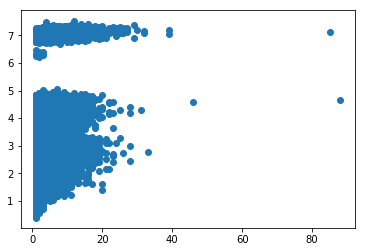

In [18]:
plt.scatter(y,yhat)
plt.show()

In [49]:
from postgres.PostgreSQL import PostgreSQL

def get_value_from_wf_df(df,ymd,col):
    return list(df[df['ymd']==ymd][col])[0]
   

def get_neighborhood_poverty(nbh):
    pov = list(poverty_df[poverty_df['neighborhood']==nbh]['percent_poverty'])
    if len(pov) == 1:
        return pov[0]
    else:
        return 'NA'

def create_dummies(vect,v,n):
    for i in range(n):
        if i == v:
            vect.append(1)
        else:
            vect.append(0)
    return vect

def ymd_check(vect,ymd,v):
    if ymd==v:
        curr_vect.append(1)
    else:
        curr_vect.append(0)
    return vect

# Call for weather forecast data to create prediction vectors
with PostgreSQL(database = 'pittsburgh') as psql:
    query = "SELECT year, month, day, temp, events FROM weather_forecasts"
    psql.execute(query)
    rows = psql.cur.fetchall()

weather_forecasts_df = pd.DataFrame(rows, columns=['year', 'month', 'day', 'temp', 'events'])
weather_forecasts_df['ymd'] = 10000 * weather_forecasts_df['year'] + 100 * weather_forecasts_df['month'] + weather_forecasts_df['day']
weather_forecasts_df

wf_df = weather_forecasts_df.groupby(['ymd'], as_index=False)['temp'].max()
events = weather_forecasts_df.groupby(['ymd'], as_index=False)['events'].count()
events['weather'] = events['events'].map(lambda x: np.where(x>0,1,0))
wf_df = pd.concat([wf_df,events['weather']], axis=1)

# feature creation month
wf_df['month'] = wf_df['ymd'].map(lambda x: int(str(x)[-4:-2]))

# feature creation day of week
dateparse = lambda x: pd.to_datetime(str(x), format='%Y%m%d')
wf_df['datetime'] = wf_df['ymd'].apply(dateparse)
wf_df['dayofweek'] = wf_df['datetime'].map(lambda x: x.dayofweek)

# get list of forecast dates
ymd_list = list(wf_df['ymd'])

if len(ymd_list) == 6:
    ymd_list = ymd_list[1:]

# populate first row of results
results = []
results.append('Neighborhood') 
for ymd in ymd_list:
    results.append(get_value_from_wf_df(wf_df,ymd,'datetime'))
    
for neighborhood in mymap.keys():
    
    # prediction result vector for neighborhood
    result = [neighborhood]

    # feature inputs
    nbh = mymap[neighborhood]
    max_nbh = np.max(list(mymap.values()))
    poverty = get_neighborhood_poverty(neighborhood)
    if poverty == 'NA': # can't make a forecast
        result.append('NA')
        result.append('NA')
        result.append('NA')
        result.append('NA')
        result.append('NA')
    else:               
        for ymd in ymd_list:
            # feature inputs
            temp = get_value_from_wf_df(wf_df,ymd,'temp')
            weather = get_value_from_wf_df(wf_df,ymd,'weather')
            month = get_value_from_wf_df(wf_df,ymd,'month')
            dayofweek = get_value_from_wf_df(wf_df,ymd,'dayofweek')

            # create feature vector
            curr_vect = []
            # add poverty
            curr_vect.append(poverty)
            # add temp
            curr_vect.append(temp)
            # add weather
            curr_vect.append(weather)
            # Jan 1
            curr_vect = ymd_check(curr_vect, str(ymd)[-4:], '0101')
            # 1st of month
            curr_vect = ymd_check(curr_vect, str(ymd)[-2:], '01')
            # 15th of month
            curr_vect = ymd_check(curr_vect, str(ymd)[-2:], '15')
            # Dec 25
            curr_vect = ymd_check(curr_vect, str(ymd)[-2:], '1225')
            # add weekday dummies
            curr_vect = create_dummies(curr_vect,dayofweek,6)
            # add month dummies
            curr_vect = create_dummies(curr_vect,month,11)
            # add weekday dummies
            curr_vect = create_dummies(curr_vect,nbh,max_nbh-1)
            print(curr_vect)
            pred = 0
            try:
                pred = clf.predict_proba(np.array(curr_vect).reshape(1, -1)).item(0)
            except:
                pass
            result.append(pred)
    results.append(result)
print(results)

[0.33960000000000001, 53.200000000000003, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.33960000000000001, 56.100000000000001, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.33960000000000001, 76.099999999999994, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0.1938, 80.900000000000006, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.80220000000000002, 53.200000000000003, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.80220000000000002, 56.100000000000001, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[1.0, 53.200000000000003, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1.0, 56.100000000000001, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1.0, 76.099999999999994, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0.375, 53.200000000000003, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.375, 56.100000000000001, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.375, 76.099999999999994, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0.31929999999999997, 53.200000000000003, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.31929999999999997, 56.100000000000001, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.31929999999999997, 76.099999999999994, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0.26429999999999998, 84.200000000000003, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.26429999999999998, 80.900000000000006, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.052400000000000002, 53.200000000000003, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0.37040000000000001, 56.100000000000001, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.37040000000000001, 76.099999999999994, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.37040000000000001, 84.200000000000003, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

[0.0, 80.900000000000006, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.20549999999999999, 53.200000000000003, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.20549999999999999, 56.100000000000001, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

[0.021399999999999999, 53.200000000000003, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0.021399999999999999, 56.100000000000001, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0.021399999999999999, 76.099999999999994, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [40]:
len(curr_vect)

117

In [41]:
curr_vect

[0.053999999999999999,
 80.900000000000006,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [45]:
lr.predict(np.array(curr_vect).reshape(1, -1)).item(0)

1.4505901336669922

In [59]:
y.shape

(188768,)

In [67]:
X.head()

,percent_poverty,temp_high,weather,jan1,1stm,15thm,dec25,mon,tue,wed,...,84,85,86,87,88,89,90,91,92,93
0,0.3396,55,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.2848,55,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.2029,55,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.5768,55,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.1938,55,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
np.min(X.temp_high)

In [70]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
model = clf.fit(X,y)
clf.score(X,y)


KeyboardInterrupt: 

In [4]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
model = clf.fit(X,y)



In [11]:
clf.predict_prob(np.array(curr_vect).reshape(1, -1)).item(0)

AttributeError: 'MultinomialNB' object has no attribute 'predict_prob'

In [18]:
from postgres.PostgreSQL import PostgreSQL
import pandas as pd
import numpy as np

path = "/data/forecasts/"

def main():
    with PostgreSQL(database = 'pittsburgh') as psql:
        query = "SELECT incidentneighborhood, x, y FROM police_incident_blotter_archive_2"
        psql.execute(query)
        rows = psql.cur.fetchall()

    # place crime data into a DataFrame
    XY_df = pd.DataFrame(rows, columns=['neighborhood','x','y'])
    XY_df = XY_df[XY_df['x']!='NaN']
    XY_df = XY_df[XY_df['y']!='NaN']

    XY_df['X'] = pd.to_numeric(XY_df['x'])
    XY_df['Y'] = pd.to_numeric(XY_df['y'])

    # count incidents by date and neighborhood
    aveXY_df = XY_df.groupby(['neighborhood'], as_index=False)[['X','Y']].mean()
    aveXY_df = aveXY_df[aveXY_df['neighborhood']!='']
    aveXY_df

    try:
        os.mkdir(path)
    except:
        pass

    aveXY_df.to_csv(path + 'coordinates.csv')

if __name__ == '__main__':
    main()


In [5]:
?pd.DataFrame.groupby
